In [5]:
import matplotlib.pyplot as plt
import gzip
from numpy import *
from numpy.linalg import *
from matplotlib import rcParams
from sklearn import linear_model
import scipy
import random
from scipy import io
import os
import pysindy as ps


In [3]:
%matplotlib inline  

In [7]:
year_raw = linspace(1845, 1903, 30)
year_raw = year_raw - 1845
hare_raw = array([20, 20, 52, 83, 64, 68, 83, 12, 36, 150, 110, 60, 7, 10, 70, 100, 92, 70, 10, 11, 137, 137, 18, 22, 52, 83, 18, 10, 9, 65])
lynx_raw = array([32, 50, 12, 10, 13, 36, 15, 12, 6, 6, 65, 70, 40, 9, 20, 34, 45, 40, 15, 15, 60, 80, 26, 18, 37, 50, 35, 12, 12, 25])
delta_t_raw = year_raw[1] - year_raw[0]

In [16]:
print(hare_raw.shape)
print(len(hare_raw))
hare_spline = scipy.interpolate.CubicSpline(year_raw, hare_raw)
lynx_spline = scipy.interpolate.CubicSpline(year_raw, lynx_raw)
year = arange(0,58+0.5, 1)
delta_t = year[1] - year[0]
hare = hare_spline(year)
lynx = lynx_spline(year)


(30,)
30


In [30]:
# t = linspace(0, 1, 100)
# x = 3 * exp(-2 * t)
# y = 0.5 * exp(t)
# X = stack((x, y), axis=-1)  # First column is x, second is y

# differentiation_method = ps.FiniteDifference(order=2)
# feature_library = ps.PolynomialLibrary(degree=3)
# optimizer = ps.STLSQ(threshold=0.2)

# model = ps.SINDy(
#     differentiation_method=differentiation_method,
#     feature_library=feature_library,
#     optimizer=optimizer,
#     feature_names=["x", "y"]
# )

library_functions = [
    lambda x : np.exp(x),
    lambda x : 1./x,
    lambda x : x,
    lambda x,y : np.sin(x+y)
]
library_function_names = [
    lambda x : 'exp(' + x + ')',
    lambda x : '1/' + x,
    lambda x : x,
    lambda x,y : 'sin(' + x + ',' + y + ')'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

X = stack((hare, lynx), axis=-1)
print(X.shape)
print(year.shape)


model = ps.SINDy(feature_library=custom_library,feature_names=["Hare", "Lynx"])
model.fit(X, t=year)
model.print()

# model.fit(X, t=t)
# model.print()

(59, 2)
(59,)


TypeError: check_is_fitted() missing 1 required positional argument: 'attributes'

### Nonlinear dynamical fit with sparse regression

In [9]:
from_end = -15
x1 = hare[1:-1]
x2 = lynx[1:-1]
# A_long = array([ones(x1.shape), x1, x2, (x1*x1), (x1*x2), (x2*x2), (x1**3), x1**2*x2, x1*x2**2, x2**3, \
#           x1**4, x1**3*x2, x1**2*x2**2, x1*x2**3, x2**4, sin(x1), cos(x1), sin(x2), cos(x2), \
#           sin(x1**2), cos(x1**2), sin(x1*x2), cos(x1*x2), sin(x2**2), cos(x2**2), \
#           sin(2*x1), cos(2*x1), sin(2*x2), cos(2*x2), sin(2*pi/10*x1), cos(2*pi/10*x1), sin(2*pi/10*x2), cos(2*pi/10*x2),\
#           sin(3*x1), cos(3*x1), sin(3*x2), cos(3*x2), sin(4*x1), cos(4*x1), sin(4*x2), cos(4*x2),
#           sin(2*pi/12*x1), cos(2*pi/12*x1), sin(2*pi/12*x2), cos(2*pi/12*x2), sin(x1**3), cos(x1**3), sin(x1**2*x2), \
#           cos(x1**2*x2), sin(x1*x2**2), cos(x1*x2**2), sin(x2**3), cos(x2**3)     ]).transpose()
# names = ["1", "x1", "x2", "x1^2", "x1x2", "x2^2", "x1^3", "x1^2x2", "x1x2^2", "x2^3", "x1^4", "x1^3x2", "x1^2x2^2", \
#         "x1x2^3", "x2^4", "sin x1", 'cos(x1)', "sin(x2)", "cos(x2)", \
#           "sin(x1**2)", "cos(x1**2)", "sin(x1*x2)", "cos(x1*x2)", "sin(x2**2)", "cos(x2**2)", \
#           "sin(2*x1)", 'cos(2*x1)', 'sin(2*x2)', 'cos(2*x2)', 'sin(2*pi/10*x1)', 'cos(2*pi/10*x1)', 'sin(2*pi/10*x2)', 'cos(2*pi/10*x2)',\
#           'sin(3*x1)', 'cos(3*x1)', 'sin(3*x2)', 'cos(3*x2)', 'sin(4*x1)', 'cos(4*x1)', 'sin(4*x2)', 'cos(4*x2)',
#           'sin(2*pi/12*x1)', 'cos(2*pi/12*x1)', 'sin(2*pi/12*x2)', 'cos(2*pi/12*x2)', 'sin(x1**3)', 'cos(x1**3)', 'sin(x1**2*x2)', \
#           'cos(x1**2*x2)', 'sin(x1*x2**2)', 'cos(x1*x2**2)', 'sin(x2**3)', 'cos(x2**3)'    ]
A = A_long[0:from_end+1,:]
# print(A.shape)
# print(len(names))
# print(A)
print(A_long.shape)
print(A.shape)
# print(A)
x1dot = zeros(len(hare)+from_end-1)
x2dot = zeros(len(lynx)+ from_end-1)
# n=length(t);
print(delta_t)
for j in range(1, len(hare)+from_end):
    x1dot[j-1]= (hare[j+1]-hare[j-1] )/(2*delta_t)
    x2dot[j-1]= (lynx[j+1]-lynx[j-1])/(2*delta_t)

rhs = array([x1dot, x2dot]).transpose()
print('rhs shape = ', rhs.shape)
print('A shape = ',A.shape)

xi = linalg.lstsq(A,rhs)[0]
print("A_long shape = ", A_long.shape)
print(xi.shape)

NameError: name 'A_long' is not defined

42
20.146370005021463


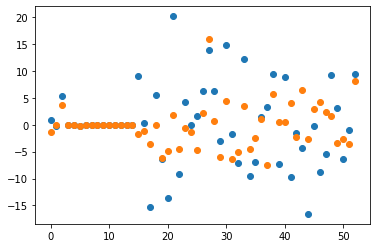

In [227]:
print(xi.argmax())
# print(xi)
print(xi.max())
plt.plot(xi, 'o')  

(58, 2)


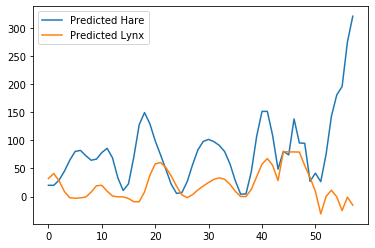

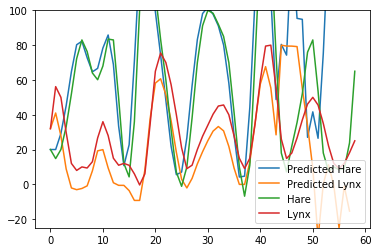

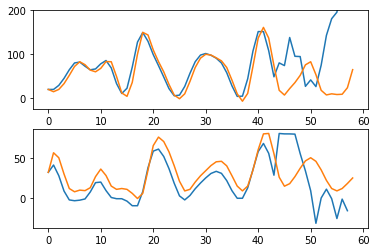

In [228]:
#predict
b = A_long @ xi;
# from_end = -1
x_t = [hare[0], lynx[0]]
answer = [x_t]
for i in range(len(b)):
    x_t = x_t + b[i]*delta_t
    answer.append(x_t)
print(array(answer).shape)
plt.plot(year[0:from_end], answer);
plt.legend(["Predicted Hare", "Predicted Lynx"])
plt.show()
plt.plot(year[0:from_end], answer);
plt.plot(year, hare)
plt.plot(year, lynx)
plt.legend(["Predicted Hare", "Predicted Lynx", "Hare", "Lynx"])
plt.ylim([-25, 100])
plt.show()
fig = plt.subplot(2,1,1)
# pred_hares = array(answer)[:,0]
fig.plot(year[0:from_end], array(answer)[:,0])
plt.ylim([-25, 200])
# fig.plot(year[from_end], array(answer)[from_end, 0], 'mo')
plt.plot(year, hare)
fig = plt.subplot(2,1,2)
# pred_hares = array(answer)[:,0]
fig.plot(year[0:from_end], array(answer)[:,1])
plt.plot(year, lynx)
plt.show()

8
[]
before =  (57, 8)
names size =  (8,)
after =  (57, 8)
(43, 8)
(43, 2)


C:\Users\16kat\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


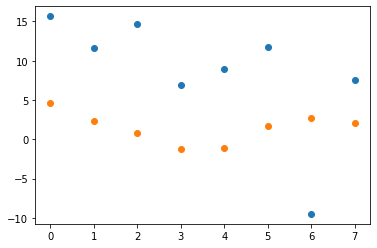

average =  6.449238126240467
terms =  8
answer shape =  (44, 2)
year end size =  (44,)
all year =  (59,)


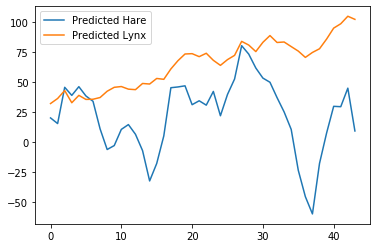

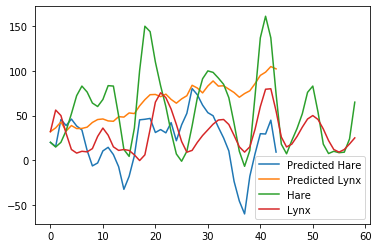

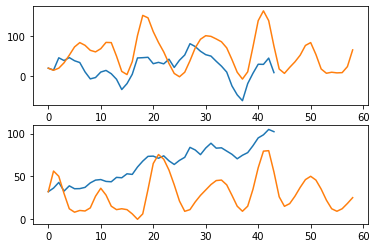

In [293]:
num_nonzero = 10
[times, terms] = A.shape
print(terms)
from_end = -15
ep = 0.1
for i in range(1):
# while terms > num_nonzero:
    index_to_delete = []
    
    for i in range(len(xi)):
            if((abs(xi[i,0])< ep) and (abs(xi[i,1])< ep)):
                index_to_delete.append(i)
    print(index_to_delete)

    print("before = ", A_long.shape)
    A_long= delete(A_long, index_to_delete, 1)   
    names= delete(names, index_to_delete)
    print("names size = ", names.shape)
    print("after = ", A_long.shape)

    A = A_long[:from_end+1,:]
    print(A.shape)
    print(rhs.shape)
    xi = linalg.lstsq(A,rhs)[0]
    plt.plot(xi, 'o') 
    plt.show()

    b = A @ xi;
    [times, terms] = A.shape
    ep = average(abs(xi))
    print("average = ", ep)
    print("terms = ", terms)
    
# from_end = -1
x_t = [hare[0], lynx[0]]
answer = [x_t]
for i in range(len(b)):
    x_t = x_t + b[i]*delta_t
    answer.append(x_t)
print("answer shape = ", array(answer).shape)
print("year end size = ", year[0:from_end].shape)
print("all year = ", year.shape)
plt.plot(year[0:from_end], answer);
plt.legend(["Predicted Hare", "Predicted Lynx"])
plt.show()
plt.plot(year[0:from_end], answer);
plt.plot(year, hare)
plt.plot(year, lynx)
plt.legend(["Predicted Hare", "Predicted Lynx", "Hare", "Lynx"])
# plt.ylim([-25, 100])
plt.show()
fig = plt.subplot(2,1,1)
# pred_hares = array(answer)[:,0]
fig.plot(year[0:from_end], array(answer)[:,0])
# plt.ylim([-25, 200])
# fig.plot(year[from_end], array(answer)[from_end, 0], 'mo')
plt.plot(year, hare)
fig = plt.subplot(2,1,2)
# pred_hares = array(answer)[:,0]
fig.plot(year[0:from_end], array(answer)[:,1])
plt.plot(year, lynx)
plt.show()

In [294]:
print(xi)

[[15.65192242  4.58704158]
 [11.61209167  2.26639234]
 [14.68303436  0.79893009]
 [ 6.891895   -1.18794153]
 [ 8.99156635 -1.12193246]
 [11.7610616   1.74618557]
 [-9.49946667  2.72371352]
 [ 7.53352595  2.13110892]]


[[ 1.36426670e+01  1.07681252e+01]
 [ 7.84235740e-01 -1.29994058e-01]
 [-2.19165022e-02  4.89829547e-01]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [-1.14337163e-02 -1.27354612e-02]
 [-1.72669318e+01 -2.29373628e+00]
 [-8.83677705e+00 -1.55722046e+00]
 [ 3.17421862e+00  5.26764015e+00]
 [-1.01789767e+01 -1.05740095e+01]
 [-8.85044091e+00  1.58419264e+00]
 [-2.76167242e+01  9.10788173e-01]
 [ 3.83358387e+01  9.56317009e-01]
 [-1.21517648e+01 -7.37300736e+00]
 [ 1.26493685e+01  3.60637250e+00]
 [ 1.81937807e+01  3.82801952e+00]
 [-1.35553801e+01 -1.06908899e+01]
 [ 3.59722967e+01  1.14134830e+01]
 [ 4.27019498e+01  3.15095756e+01]
 [ 6.57366008e+00  1.13065111e+01]
 [ 6.34897672e+00 -3.68071365e+00]
 [-3.02186297e+01  4.39663546e+00]
 [ 5.79967934e+01  1.14674908e+01]
 [ 8.13913051e+00 -6.71323595e+00]
 [ 4.16138873e+01  1.00798112e+01]
 [-5.25728166e+00  4.21396328e+00]
 [-9.85033817e+00 -1.15918929e+00]
 [ 1.10901443e+01  9.90135886e+00]
 [ 3.23201586e+01 -1

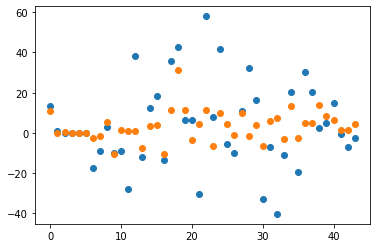

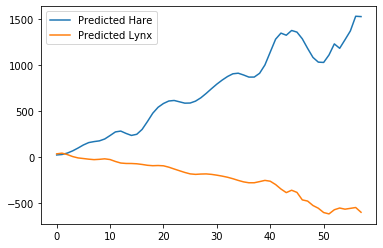

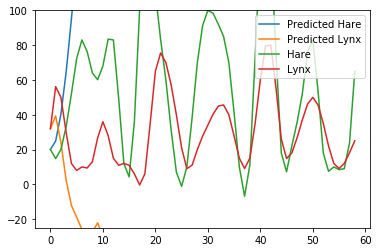

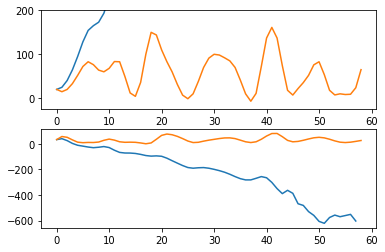

In [225]:
# print(xi)
xi_less = zeros(xi.shape)
ep = 0.01
for i in range(len(xi)):
    for j in range(len(xi[0])):
        if(abs(xi[i,j])> ep):
            xi_less[i,j] = xi[i,j]
            
print(xi_less)
plt.plot(xi_less, 'o')
plt.show()
b = A_long @ xi_less;
from_end = -1
x_t = [hare[0], lynx[0]]
answer = [x_t]
for i in range(len(b)):
    x_t = x_t + b[i]*delta_t
    answer.append(x_t)
# print(array(answer).shape)
plt.plot(year[0:from_end], answer);
plt.legend(["Predicted Hare", "Predicted Lynx"])
plt.show()
plt.plot(year[0:from_end], answer);
plt.plot(year, hare)
plt.plot(year, lynx)
plt.legend(["Predicted Hare", "Predicted Lynx", "Hare", "Lynx"])
plt.ylim([-25, 100])
plt.show()
fig = plt.subplot(2,1,1)
# pred_hares = array(answer)[:,0]
fig.plot(year[0:from_end], array(answer)[:,0])
plt.ylim([-25, 200])
fig.plot(year[-14], array(answer)[-14, 0], 'mo')
plt.plot(year, hare)
fig = plt.subplot(2,1,2)
# pred_hares = array(answer)[:,0]
fig.plot(year[0:from_end], array(answer)[:,1])
plt.plot(year, lynx)
plt.show()

(43, 45)


C:\Users\16kat\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1676.2539763083018, tolerance: 3.042789802194585
  positive)
C:\Users\16kat\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 614.5227629745191, tolerance: 0.637867583355703
  positive)


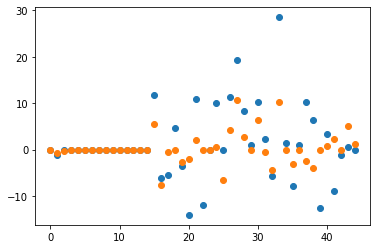

In [215]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(A, rhs)
print(A.shape)
x = clf.coef_
x = transpose(x)
# print(x)
plt.plot(x, 'o')  
plt.show()


[   20.           -24.52633039   -52.82389138   -93.2903238
  -102.28300879  -127.2827292   -160.75755232  -209.04333542
  -257.74614433  -297.94555596  -325.32893538  -352.25869331
  -416.67824075  -485.26712445  -552.5223673   -583.34158933
  -579.11929701  -570.36506428  -589.83665167  -643.50334876
  -712.66069447  -783.69994809  -856.19789644  -913.83501251
  -971.108434   -1009.00787642 -1029.57997016 -1045.10623316
 -1064.90348033 -1089.94305271 -1141.21293628 -1178.9653216
 -1226.6065093  -1274.54160732 -1334.71755141 -1408.44958927
 -1472.42246957 -1512.42728438 -1513.6809024  -1496.85065425
 -1505.25129678 -1548.68056215 -1625.22088962 -1723.4633155
 -1744.31570266 -1788.2813897  -1830.27537596 -1912.16018675
 -1941.47342164 -2000.7539576  -2008.34032635 -2036.05913818
 -2047.27343796 -2079.90866077 -2092.71237727 -2073.92754189
 -2020.81622936 -2062.57108756]


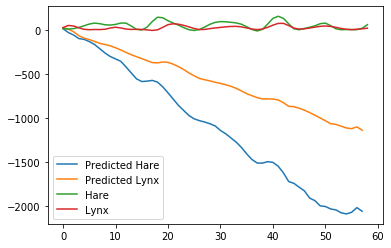

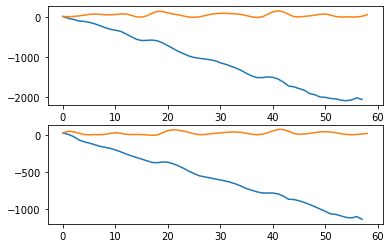

In [216]:
#predict
b = A_long @ x;
# print(b)
# x_0 = [hare[0], lynx[0]]
# answer = []
# for i in range(len(b)):
#     answer.append(x_0 + b[i]*delta_t)
# print(b)
from_end = -1
x_t = [hare[0], lynx[0]]
answer = [x_t]
for i in range(len(b)):
    x_t = x_t + b[i]*delta_t
    answer.append(x_t)
print(array(answer)[:,0])
plt.plot(year[0:from_end], answer);
plt.plot(year, hare)
plt.plot(year, lynx)
plt.legend(["Predicted Hare", "Predicted Lynx", "Hare", "Lynx"])
plt.show()
fig = plt.subplot(2,1,1)
# pred_hares = array(answer)[:,0]
fig.plot(year[0:from_end], array(answer)[:,0])
plt.plot(year, hare)
fig = plt.subplot(2,1,2)
# pred_hares = array(answer)[:,0]
fig.plot(year[0:from_end], array(answer)[:,1])
plt.plot(year, lynx)
plt.show()